In [1]:
'''
Script per fare inferenza su nuove immagini a 16-bit
'''

'\nScript per fare inferenza su nuove immagini a 16-bit\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Caricamento librerie
from fastai.vision.all import *
from fastai.torch_core import set_seed

import os
import sys
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects

In [4]:
# Settaggio iper-parametri e generatore random
SEED = 123
IMG_SIZE = 512
BS = 16

set_seed(SEED, reproducible=True)

In [5]:
# Loss-function che penalizza la frammentazione delle maschere 
def regularization_loss(y_pred):
    dx = torch.abs(y_pred[:, :, 1:] - y_pred[:, :, :-1])
    dy = torch.abs(y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1])
    reg_loss = torch.mean(dx) + torch.mean(dy)
    return reg_loss

# Loss-function combinata, basata su Crossentropy-loss
def combined_loss(y_pred, y_true):
    ce_loss = F.cross_entropy(y_pred, y_true, weight=wgts)
    reg_loss = regularization_loss(y_pred)
    total_loss = ce_loss + reg_loss 
    return total_loss

In [6]:
# Caricamento del modello finale preaddestrato
learn_path = '/kaggle/input/large-debris/export_large.pkl'

learn = load_learner(learn_path, cpu=False) #cpu=False!!!

learn.dls.to(device='cuda') # device='cuda'
learn.model.to(device='cuda') # device='cuda'

print('Modello caricato corretamente!!')

Modello caricato corretamente!!


In [7]:
# Caricamento immagine - ridimensionamento a 512x512 pixel - trasformazione a 8 bit 
image_path = '/kaggle/input/large-debris/Images120/Images120/image_31.png' 

image = Image.open(image_path)

if image.size != (IMG_SIZE, IMG_SIZE):
    image = image.resize((IMG_SIZE, IMG_SIZE))

base_name = os.path.basename(image_path)
image_8bit = image.point(lambda x: x * (1.0 / 256)).convert('L')

saved_img_8bit = f'/kaggle/working/{base_name}'
image_8bit.save(saved_img_8bit)

In [12]:
%%time

# Inferenza
pred_mask, pred_class, pred_probs = learn.predict(image_8bit)
pred_mask_np = np.array(pred_mask[0].numpy())

threshold = 0.5
binary_mask = (pred_mask_np > threshold).astype(np.uint8) 

binary_mask_image = Image.fromarray(binary_mask * 255)

CPU times: user 103 ms, sys: 4.4 ms, total: 107 ms
Wall time: 81.4 ms


In [9]:
# Estrapolazione coordinate da maschera
def find_highest_lowest_xy(mask):
    # Estrapolazione regioni indipendenti formate pixel 0
    labeled_mask, num_features = label(mask == 0)
    
    if num_features == 0: 
        sys.exit('Nessuna Maschera Rilevata')
    
    # Conteggio pixel per regione
    sizes = [np.sum(labeled_mask == i) for i in range(1, num_features + 1)]
    
    # Calcolo regione avente più pixel
    largest_index = np.argmax(sizes) + 1  
    
    # Calcolo coordinate regione più grande
    largest_region_coords = np.argwhere(labeled_mask == largest_index)
    
    # Calcolo coordinate degli estremi della regione più grande
    ymin = np.min(largest_region_coords[:, 0])
    ymax = np.max(largest_region_coords[:, 0])
    xmin = np.min(largest_region_coords[:, 1])
    xmax = np.max(largest_region_coords[:, 1])
    
    if ymin == ymax:  # In caso di regione orizzontale
        y_near_mask = [ymin, ymin]
        x_near_mask = [xmin, xmax]
    elif xmin == xmax:  # In caso di regione verticale
        y_near_mask = [ymin, ymax]
        x_near_mask = [xmin, xmin]
    else:  # Per le altre forme
        dist_ymin = abs(largest_region_coords[:, 0] - ymin)
        dist_ymax = abs(largest_region_coords[:, 0] - ymax)
        dist_xmin = abs(largest_region_coords[:, 1] - xmin)
        dist_xmax = abs(largest_region_coords[:, 1] - xmax)
        y_near_mask = [ymin, ymax]
        x_near_mask = [largest_region_coords[np.argmin(dist_ymin), 1], largest_region_coords[np.argmin(dist_ymax), 1]]
    
    return (y_near_mask, x_near_mask)

y_coords, x_coords = find_highest_lowest_xy(binary_mask)

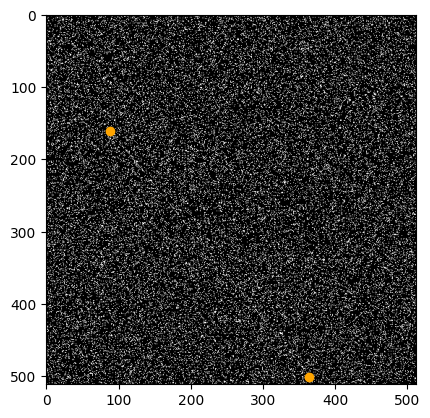

X0: 88 --- Y0: 161
X1: 364 --- Y1: 501


In [10]:
# Visualizzazione risultati
image = plt.imread(saved_img_8bit)
plt.imshow(image, cmap='gray') 

plt.scatter(x_coords, y_coords, color='orange') 

plt.show()

print(f'X0: {x_coords[0]} --- Y0: {y_coords[0]}')
print(f'X1: {x_coords[1]} --- Y1: {y_coords[1]}')

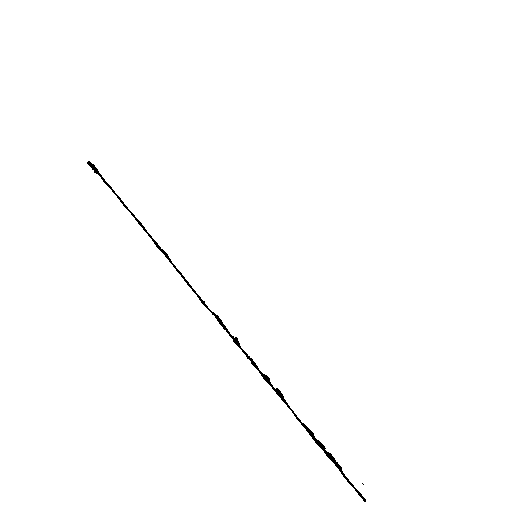

In [11]:
binary_mask_image